In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
#!unzip -q /content/gdrive/MyDrive/test_fake_news.zip
#!unzip -q /content/gdrive/MyDrive/train_fake_news.zip

In [ ]:
import pandas as pd

import nltk
from nltk.corpus import stopwords
import string

import torch
import torchtext
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

from transformers import BertModel

import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from transformers import get_linear_schedule_with_warmup

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_db = pd.read_csv('train.csv')
test_db = pd.read_csv('test.csv')

Let's take a look at the information about the dataset and make the 'id' column an index.

In [ ]:
train_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
train_db.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
train_db.set_index('id', inplace=True)

In [ ]:
test_db.set_index('id', inplace=True)

Let's see if there are any missing values in the columns.

In [ ]:
missing_percentages = (train_db.isnull().mean() * 100).round(2)
print(missing_percentages)

title     2.68
author    9.41
text      0.19
label     0.00
dtype: float64


There are missing values, so let's do the following: in the case of the text, remove the missing values (they are less than one percent, so it's not a problem), in the case of the author and title, replace them with known patterns. For example, an unavailable author will be marked as Unknow, and the title will be marked as No title.

In [ ]:
train_db.dropna(subset=['text'], inplace=True)
train_db['author'].fillna('Unknown', inplace=True)
train_db['title'].fillna('No title', inplace=True)

In [ ]:
test_db['text'].fillna('Unknown', inplace=True)
test_db['author'].fillna('Unknown', inplace=True)
test_db['title'].fillna('No title', inplace=True)

The missing values have been filled in. Now we need to prepare the text for training. I decided to leave all the information in the data (author, title, and text combined). The title and author's name are often an indicator of the quality of the news.

In [ ]:
train_db = train_db.assign(combined='Title:' + train_db['title'] + '\nAuthor:' + train_db['author'] + '\nBody:' + train_db['text'])
data_combined = train_db[['combined', 'label']]

In [ ]:
test_db = test_db.assign(combined='Title:' + test_db['title'] + '\nAuthor:' + test_db['author'] + '\nBody:' + test_db['text'])
test_data_combined = test_db[['combined']]

Now let's prepare the data for training. The plan is as follows:
1. Translate all the text into lowercase. This is necessary to reduce the dimensionality of the data and unify the words.

In [ ]:
def process_dataset_pandas(dataframe, text_column):
    dataframe.loc[:, text_column] = dataframe[text_column].str.lower()
    return dataframe

In [ ]:
data_combined = process_dataset_pandas(data_combined, 'combined')

In [ ]:
test_data_combined = process_dataset_pandas(test_data_combined, 'combined')

In [ ]:
data_combined.head()

,combined,label
id,,
0,title:house dem aide: we didn’t even see comey...,1
1,"title:flynn: hillary clinton, big woman on cam...",0
2,title:why the truth might get you fired\nautho...,1
3,title:15 civilians killed in single us airstri...,1
4,title:iranian woman jailed for fictional unpub...,1


After preliminary data preparation, you need to make dataloaders. I created a class for this purpose. Its functionality:
1. Tokenization.
2. Cleaning up stop words and punctuation. We remove stop words. Usually, words like 'and', 'so', etc. are meaningless, so we remove them to improve the quality of the model and remove noise.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def remove_stopwords_and_punctuation(self, text):
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word.lower() not in stop_words and word not in punctuation]
        return ' '.join(tokens)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['combined']
        label = self.data.iloc[idx]['label']
        text = self.remove_stopwords_and_punctuation(text)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
max_length = 128
batch_size = 8
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Let's split the set into test and validation sets, create datasets and dataloads.

In [ ]:
train_data, test_data = train_test_split(data_combined, test_size=0.2, random_state=42)

In [ ]:
train_dataset = CustomDataset(train_data, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CustomDataset(test_data, tokenizer, max_length)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_data_combined['label'] = None
test_data_combined['label'] = test_data_combined['label'].fillna(1, inplace=True).astype(int)

In [ ]:
test_dataset = CustomDataset(test_data_combined, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Once the loads are created, let's move on to initializing the model. Let's load BERT. I chose BertForSequenceClassification for this task - it is a BERT implementation that was specially designed for classification tasks. The regular BERT is usually used for other tasks, such as filling in gaps in text or generating.

In [ ]:
device = torch.device('cuda')

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)

Set the optimizer.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00001)

Let's set the number of epochs.

In [ ]:
epochs = 3

Create a function to calculate the Accuracy, since it is taken into account in Kaggle competitions.

In [ ]:
def calc_acc(preds, labels):
    preds = np.argmax(preds, axis=1).ravel()
    labels = labels.ravel()
    return accuracy_score(preds, labels)

Initialize the cycle for training and validation of the model, during which we calculate the accuracy and losses for both training and validation data.

In [ ]:
training_arr = []
for epoch in range(epochs):
    train_loss = 0
    train_acc = 0

    model.train()
    train_progress = tqdm(enumerate(train_dataloader), desc="Training (Epoch {})".format(epoch))
    for step, batch in train_progress:
        id, mask, label = batch['input_ids'].to(device).to(torch.int64), batch['attention_mask'].to(device).to(torch.int64), batch['label'].to(device).to(torch.int64)
        model.zero_grad()
        loss, logits = model(id, token_type_ids=None, attention_mask=mask, labels=label)[0], model(id, token_type_ids=None, attention_mask=mask, labels=label)[1]
        train_loss += loss.item()
        logits = logits.detach().to('cpu').numpy()
        label_ids = label.to('cpu').numpy()
        train_acc += calc_acc(logits, label_ids)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_progress.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_accuracy = train_acc / len(train_dataloader)

    model.eval()
    val_accuracy = 0
    val_loss = 0
    val_progress = tqdm(val_dataloader, desc="Validation (Epoch {})".format(epoch))
    for batch in val_progress:
        id, mask, label = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        with torch.no_grad():
            loss, logits = model(id, token_type_ids=None, attention_mask=mask, labels=label)[0], model(id, token_type_ids=None, attention_mask=mask, labels=label)[1]
        val_loss += loss.item()
        logits = logits.detach().to('cpu').numpy()
        label_ids = label.to('cpu').numpy()
        val_accuracy += calc_acc(logits, label_ids)

        val_progress.set_postfix({'loss': loss.item()})

    avg_val_accuracy = val_accuracy / len(val_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)

    training_arr.append({
        'epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Training Accuracy': avg_train_accuracy,
        'Validation Loss': avg_val_loss,
        'Validation Accuracy': avg_val_accuracy
    })

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')


Training (Epoch 0): 2076it [14:49,  2.33it/s, loss=4.26e-5]
Validation (Epoch 0): 100%|██████████| 520/520 [02:20<00:00,  3.69it/s, loss=5.13e-6]


Epoch 1/3, Train Loss: 0.0077, Train Acc: 0.9988, Val Loss: 0.0100, Val Acc: 0.9981


Training (Epoch 1): 2076it [14:54,  2.32it/s, loss=5.93e-6]
Validation (Epoch 1): 100%|██████████| 520/520 [02:20<00:00,  3.70it/s, loss=3.46e-6]


Epoch 2/3, Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.0023, Val Acc: 0.9985


Training (Epoch 2): 2076it [14:51,  2.33it/s, loss=4.9e-6]
Validation (Epoch 2): 100%|██████████| 520/520 [02:19<00:00,  3.72it/s, loss=3.46e-6]

Epoch 3/3, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0042, Val Acc: 0.9985


In [ ]:
train_loss = training_arr['Training Loss']
val_loss = training_arr['Validation Loss']
train_acc = training_arr['Training Accuracy']
val_acc = training_arr['Validation Accuracy']
epochs = [1, 2, 3]

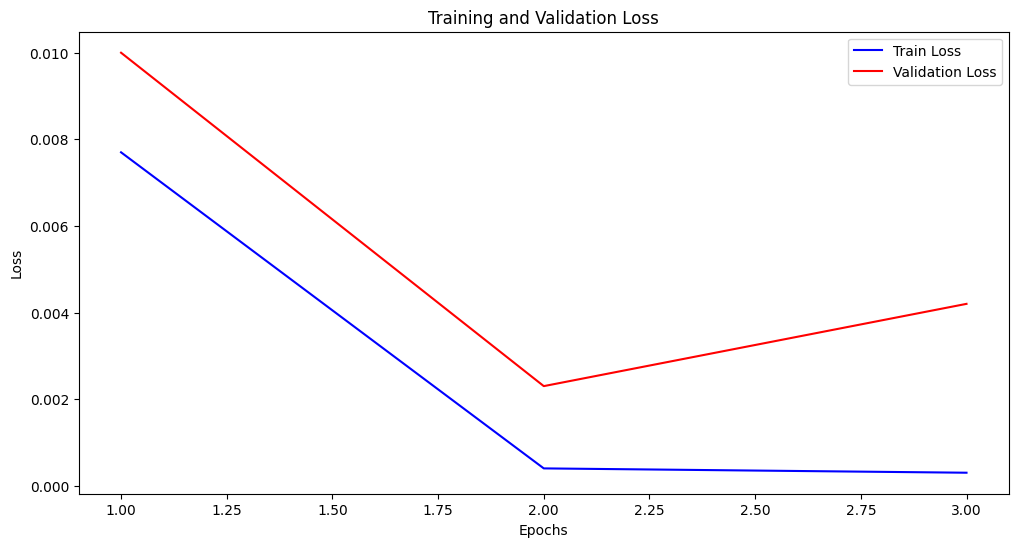

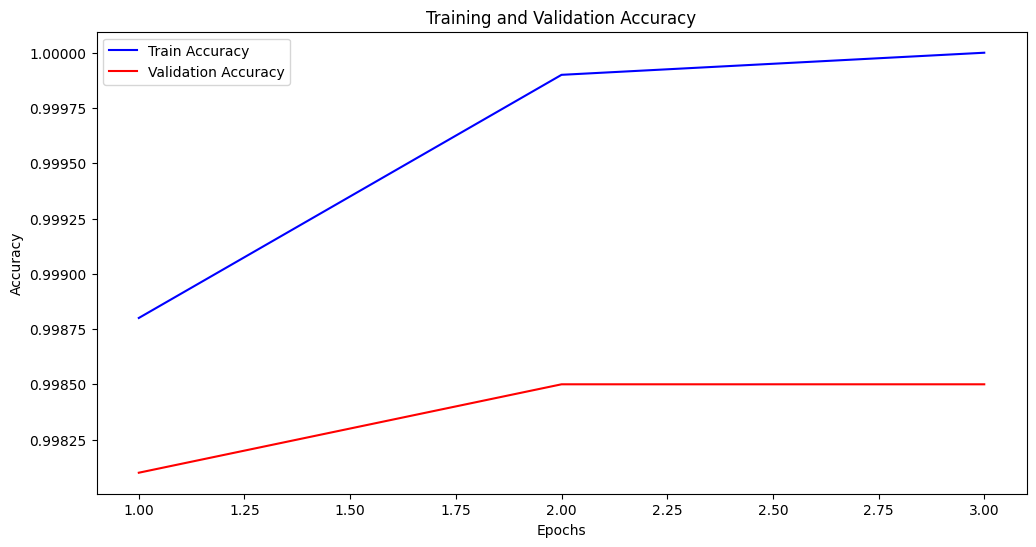

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


As you can see, three epochs are enough to train a model on data. Let's save the weights for the possibility of further work with them.

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

Perform predictions on test data from kaggle.

In [ ]:
model.eval()
predictions = []
for batch in test_dataloader:
  id, mask, label = batch['input_ids'].to(device).to(torch.int64), batch['attention_mask'].to(device).to(torch.int64), batch['label'].to(device).to(torch.int64)
  with torch.no_grad():
    logits = model(id, token_type_ids=None, attention_mask=mask)[0]
  logits = logits.detach().to('cpu').numpy()
  predictions.append(logits)

In [ ]:
predictions = [item for sublist in predictions for item in sublist]
predictions = np.argmax(predictions, axis=1).flatten()

In [ ]:
submission = pd.read_csv('/content/submit.csv')
submission['label'] = predictions
submission.head(10)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
5,20805,1
6,20806,0
7,20807,1
8,20808,1
9,20809,1


In [ ]:
submission.to_csv('submission1.csv', index= False)

Score on kaggle.

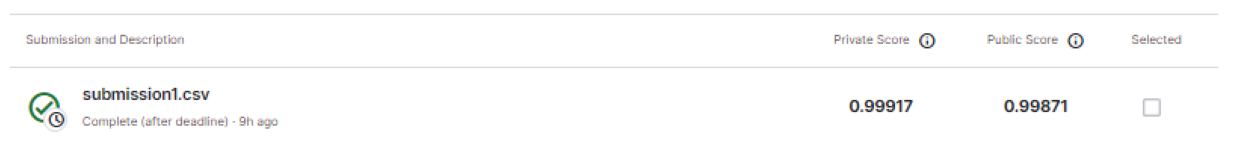

In [ ]:
import matplotlib.pyplot as plt
image = plt.imread('/content/screen.PNG')
plt.figure(figsize=(16, 12))
plt.axis('off')
plt.imshow(image)
plt.show()